In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras_tuner import RandomSearch

In [2]:
(x_data, y_data), (x_test, y_test) = mnist.load_data()

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [5]:
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [6]:
def preprocess(image, label):
    # Add channel dimension and resize image
    image = tf.expand_dims(image, axis=-1)
    image = tf.image.resize(image, (224, 224))
    image = tf.image.grayscale_to_rgb(image)
    return image, tf.one_hot(label, 10)

In [7]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [16]:
def build_model(hp):
    inputs = layers.Input(shape=(224, 224, 3))

    # Initial Conv layer
    filters = hp.Choice('filters', values=[32, 64])
    x = layers.Conv2D(filters, (7, 7), strides=(2, 2), padding='same', activation=hp.Choice('activation', values=['relu', 'tanh']))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual Block 1
    for _ in range(2):
        shortcut = x
        x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)

    # Residual Block 2 with dimensionality adjustment
    for _ in range(2):
        shortcut = x
        if x.shape[-1] != 2 * filters:
            shortcut = layers.Conv2D(2 * filters, (1, 1), strides=(1, 1), padding='same')(shortcut)
        x = layers.Conv2D(2 * filters, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(2 * filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)

    nodes = hp.Choice('nodes', values=[128, 256, 512])

    # Global Average Pooling and Dense output layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(nodes, activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout_rate', 0.3, 0.5, step=0.1))(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [17]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='mnist_tuning',
    project_name='mnist_resnet'
)

In [18]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [19]:
tuner.search(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

Trial 10 Complete [00h 18m 12s]
val_accuracy: 0.8334166407585144

Best val_accuracy So Far: 0.9776666760444641
Total elapsed time: 04h 11m 23s


In [20]:
best_hps = tuner.get_best_hyperparameters(1)[0]

In [21]:
print(f"Best hyperparameters: Filters: {best_hps.get('filters')}, Activation: {best_hps.get('activation')}, Learning Rate: {best_hps.get('learning_rate')}, Dropout Rate: {best_hps.get('dropout_rate')}")

Best hyperparameters: Filters: 32, Activation: relu, Learning Rate: 0.0001, Dropout Rate: 0.4


In [22]:
best_model = tuner.hypermodel.build(best_hps)

In [23]:
history = best_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/10
1500/1500 [==============================] - 136s 90ms/step - loss: 1.0976 - accuracy: 0.6796 - val_loss: 1.4790 - val_accuracy: 0.5441
Epoch 2/10
1500/1500 [==============================] - 133s 89ms/step - loss: 0.3499 - accuracy: 0.9189 - val_loss: 1.4781 - val_accuracy: 0.5303
Epoch 3/10
1500/1500 [==============================] - 133s 88ms/step - loss: 0.2144 - accuracy: 0.9471 - val_loss: 0.6321 - val_accuracy: 0.7803
Epoch 4/10
1500/1500 [==============================] - 134s 90ms/step - loss: 0.1671 - accuracy: 0.9570 - val_loss: 0.4418 - val_accuracy: 0.8326
Epoch 5/10
1500/1500 [==============================] - 133s 88ms/step - loss: 0.1398 - accuracy: 0.9629 - val_loss: 0.3224 - val_accuracy: 0.9041
Epoch 6/10
1500/1500 [==============================] - 132s 88ms/step - loss: 0.1202 - accuracy: 0.9682 - val_loss: 0.2122 - val_accuracy: 0.9361
Epoch 7/10
1500/1500 [==============================] - 132s 88ms/step - loss: 0.1071 - accuracy: 0.9705 - val_loss: 3

In [24]:
best_model.save('mnist_best_resnet.h5')

In [25]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")

Training Accuracy: 0.9771875143051147
Validation Accuracy: 0.965749979019165


In [26]:
y_pred = best_model.predict(test_ds)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()
y_true = y_test.flatten()

313/313 [==============================] - 10s 30ms/step


In [27]:
report = classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(10)])
print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.94      0.96      1032
           3       0.85      1.00      0.92      1010
           4       0.98      0.99      0.98       982
           5       0.96      0.98      0.97       892
           6       1.00      0.96      0.98       958
           7       1.00      0.92      0.96      1028
           8       0.96      0.97      0.97       974
           9       0.99      0.94      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



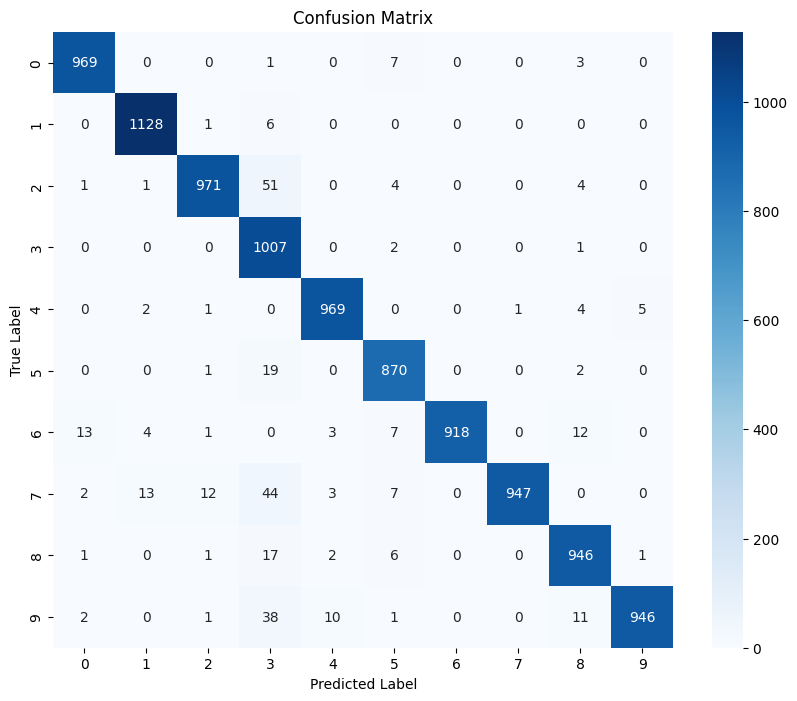

In [28]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()